In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import random
import math
import matplotlib.pyplot as plt

## random generate numbers
n = 10000
d = 10
x = np.random.normal(size=(n,d))
error = np.random.normal(size=(n,1))

b = np.random.uniform(size=(d,1))

### in order to avoid Perfect Separation, we need to add some noise
y = x@b + error

In [2]:
class data_generate_process:
    def __init__(self, x, y):
        self.x = x
        self.y = y    
        
    def split(self, rate = 0.7, random_state = 1024, scale = False):
        ## Feature scaling is used to normalize the range of independent variables or features of data
        if scale:
            self.x = (self.x - np.mean(self.x))/x.std()
        
        n = len(self.y)
        np.random.seed(random_state)
        
        ##randomly spilte data into 70% train and 30% test
        index = list(range(n))
        np.random.shuffle(index)
        train = index[:int(rate*n)]
        test = index[int(rate*n):]
        
        self.train_x = self.x[train]
        self.test_x = self.x[test]
        self.train_y = self.y[train]
        self.test_y = self.y[test]
        
        return self.train_x, self.test_x, self.train_y, self.test_y

class model:
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def bias(self, intercept):
        ## if need intercept, add column x0 as 1
        if intercept:
            n = len(self.x)
            ones = np.ones((n,1))
            return np.hstack([ones,self.x])
        return self.x
    
    def tidy(self, x, tails = 2):
        
        n, k = x.shape
        self.error = self.y - x@self.beta 

        self.vb = self.error.var()*np.linalg.inv(x.T@x)
        self.se = np.sqrt(np.diagonal(self.vb)).reshape(-1,1)
        self.t = np.divide(self.beta,self.se)
        self.pval = tails * (1 - stats.norm.cdf(self.t))
        
        names = ['Coef','Std err','t','p-value']
        values = [self.beta, self.se, self.t, self.pval]
        values = np.hstack(values)
        
        self.summary = pd.DataFrame(values, columns =names)

        self.rsq = 1 - self.error.var()/self.y.var()
        self.adjrsq = self.rsq*(n -1)/(n-k-1)
        
        var = self.error.var()
        ## sum function here is useless, but just in order to get a list, rather than a list in a list
        ## in this case, it's easily to plot graph
        self.sse = sum(self.error.T@self.error)
        
        logl = -n/2*np.log(2*var*math.pi) - 1/2/var*self.sse
        self.logl = logl.tolist()
        
        self.aic = -2*(logl)+ 2*k 
        self.bic = -2*(logl)+ k*np.log(n) 
        
        names = ['r.squared','adj.rsq','df','loglikehood','aic','bic']
        values = [self.rsq,self.adjrsq,n-k-1,logl,self.aic,self.bic]
        glance= pd.DataFrame(columns = ['r.squared','adj.rsq','df','loglikehood','aic','bic'])
        glance.loc[0] = values
        
        self.glance = glance 
        return  self.summary
    
    def least_square(self, intercept = False):
        x = self.bias(intercept)
        
        xx = x.T@x
        xy = x.T@self.y
        
        self.beta = np.linalg.solve(xx,xy)
        return self.tidy(x)
    
    def ridge(self, intercept = False, lumda = 0.2):
        x = self.bias(intercept)
        
        I = lumda*np.identity(x.shape[1])
        xy = x.T@self.y
        xx = x.T@x
        self.beta = np.linalg.inv(xx+ I)@xy
        return self.tidy(x)
    
    
    def gradient_descent(self, learning_rate = 0.01, iterations = 10000, threshold = 1e-5, intercept = False, random =False):

        x = self.bias(intercept)
        m, n = np.shape(x)
        
        if random:
                ## random start
            beta = np.random.randn(n).reshape(-1,1)
        else:
            ## init beta = [1,1,1]
            beta = np.ones(n).reshape(-1,1)  
        
        for i in range(iterations):

            error = x@beta - self.y
            update = - (1/m)*learning_rate*x.T@error
            beta += update
            
            ## threshold measure if learning step is accuracy
            if np.abs(update).sum()< threshold:
                self.beta = beta
                return self.tidy(x)
            
        return Exception('Gradient did not converge')
    
    def predict(self, x, beta = None):
        if beta is None:
            return x@self.beta
        
        return x@beta
    
    def performance(self, test_y, y_pred):
        ### sum function makeds nothing but return a value that makes it easier to plot 
        return sum((test_y - y_pred).T@(test_y - y_pred))
        
            
train_x, test_x, train_y, test_y = data_generate_process(x, y).split()

## Ordinary Least Square
$Beta = {(XX')} ^{-1}XY $
## Ridge
$Beta = {(XX'+ I)} ^{-1}XY $
## Gradient Descent
$Beta = Beta + learningRate * X' Error$


In [3]:
ols = model(train_x, train_y)
ols.least_square()

,Coef,Std err,t,p-value
0,0.568921,0.011592,49.079583,0.000000e+00
1,0.511895,0.011722,43.671179,0.000000e+00
2,0.130392,0.011688,11.155703,0.000000e+00
3,0.923494,0.011588,79.693100,0.000000e+00
4,0.562558,0.011858,47.442980,0.000000e+00
5,0.585283,0.011628,50.334591,0.000000e+00
6,0.084285,0.011859,7.106970,1.186162e-12
7,0.794196,0.011779,67.425171,0.000000e+00
8,0.002680,0.011766,0.227724,8.198609e-01
9,0.350027,0.011939,29.319164,0.000000e+00


In [4]:
ols.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.752167,0.753243,6989,[-9842.197008686257],[19704.394017372513],[19772.930671652888]


In [5]:
import statsmodels.api as sm

results = sm.OLS(train_y, train_x).fit()
# Inspect the results and compared to the result in the package I built
print(results.summary())
## it's the same between OLS and this package

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.752
Model:                            OLS   Adj. R-squared (uncentered):              0.752
Method:                 Least Squares   F-statistic:                              2122.
Date:                Wed, 15 Jul 2020   Prob (F-statistic):                        0.00
Time:                        20:32:50   Log-Likelihood:                         -9842.2
No. Observations:                7000   AIC:                                  1.970e+04
Df Residuals:                    6990   BIC:                                  1.977e+04
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [6]:
ridge = model(train_x, train_y)
ridge.ridge()

,Coef,Std err,t,p-value
0,0.568905,0.011592,49.078256,0.000000e+00
1,0.511880,0.011722,43.669940,0.000000e+00
2,0.130389,0.011688,11.155426,0.000000e+00
3,0.923469,0.011588,79.690953,0.000000e+00
4,0.562542,0.011858,47.441633,0.000000e+00
5,0.585266,0.011628,50.333139,0.000000e+00
6,0.084283,0.011859,7.106823,1.187495e-12
7,0.794173,0.011779,67.423261,0.000000e+00
8,0.002679,0.011766,0.227704,8.198760e-01
9,0.350017,0.011939,29.318342,0.000000e+00


In [7]:
ridge.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.752167,0.753243,6989,[-9842.197016888187],[19704.394033776374],[19772.93068805675]


In [8]:
gradient_descent = model(train_x, train_y)
gradient_descent.gradient_descent()

,Coef,Std err,t,p-value
0,0.569014,0.011592,49.087642,0.000000e+00
1,0.511981,0.011722,43.678548,0.000000e+00
2,0.130490,0.011688,11.164102,0.000000e+00
3,0.923461,0.011588,79.690242,0.000000e+00
4,0.562628,0.011858,47.448881,0.000000e+00
5,0.585388,0.011628,50.343656,0.000000e+00
6,0.084453,0.011859,7.121150,1.070255e-12
7,0.794218,0.011779,67.427099,0.000000e+00
8,0.002858,0.011766,0.242860,8.081136e-01
9,0.350145,0.011939,29.329024,0.000000e+00


In [9]:
gradient_descent.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.752167,0.753243,6989,[-9842.197434761234],[19704.394869522468],[19772.931523802843]


In [10]:
random_gradient_descent = model(train_x, train_y)
random_gradient_descent.gradient_descent(random = True)

,Coef,Std err,t,p-value
0,0.568823,0.011592,49.071109,0.000000e+00
1,0.511931,0.011722,43.674309,0.000000e+00
2,0.130387,0.011688,11.155239,0.000000e+00
3,0.923353,0.011588,79.680987,0.000000e+00
4,0.562209,0.011858,47.413529,0.000000e+00
5,0.585229,0.011628,50.329949,0.000000e+00
6,0.084402,0.011859,7.116872,1.104006e-12
7,0.794228,0.011779,67.427956,0.000000e+00
8,0.002639,0.011766,0.224259,8.225560e-01
9,0.349921,0.011939,29.310288,0.000000e+00


In [11]:
random_gradient_descent.glance

,r.squared,adj.rsq,df,loglikehood,aic,bic
0,0.752167,0.753243,6989,[-9842.19766647769],[19704.39533295538],[19772.931987235756]


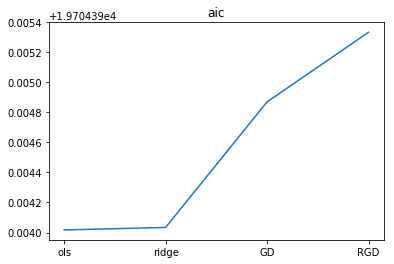

In [12]:
## Model Evulation
### 1.compared by AIC
algorithms = [ols, ridge, gradient_descent, random_gradient_descent]
names  = ['ols', 'ridge', 'GD', 'RGD']
criterion = [item.aic for item in algorithms]
plt.title('aic')
plt.plot(names , criterion)


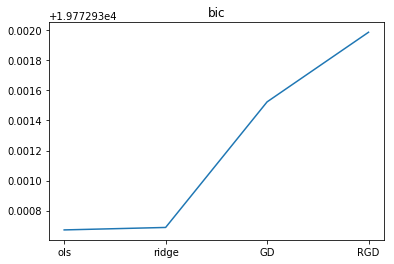

In [13]:
### 2.compared by bic
criterion = [item.bic for item in algorithms]
plt.title('bic')
plt.plot(names , criterion)

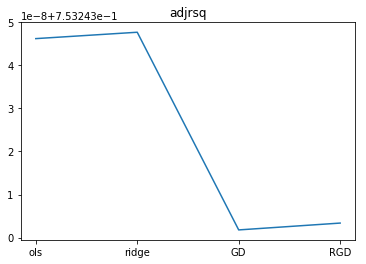

In [14]:
### 3.compared by adjrsq
criterion = [item.adjrsq for item in algorithms]
plt.title('adjrsq')
plt.plot(names , criterion)

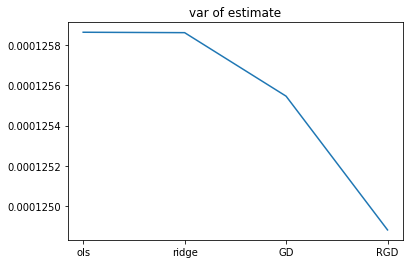

In [15]:
### 4.compared by beta.var
criterion = [(item.beta - b).var() for item in algorithms]
plt.title('var of estimate')
plt.plot(names , criterion)

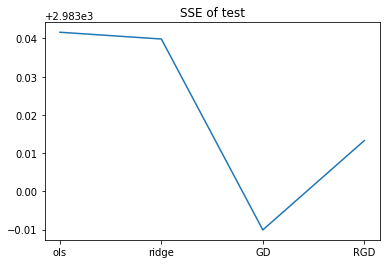

In [16]:
## 5.compared by SSE of Testing
betas = [item.beta for item in algorithms]
sse = []
for beta in betas:
    linear = model(train_x, train_y)
    y_pred = linear.predict(test_x, beta)
    sse.append(ridge.performance(test_y, y_pred))
plt.title('SSE of test')
plt.plot(names, sse)